# Reinforcement learning

Reinforcement learning komt uit de studie van Markov Chains of Processen voor.
Dit is een random opeenvolging van states waarbij elke transisitie een mogelijke kans heeft.
Door een reward te koppelen aan elke state waarin je komt kan je een functie opstellen die de de totale reward maximaliseert.
Dit is het basisidee achter reinforcement learning.

Een aantal belangrijke termen/concepten hierbij zijn:
* De agent
* Het environment
* De state space
* De action space
* De reward en return
* Exploration vs exploitation

## Q-learning

Een eerste algoritme dat we bekijken voor reinforcement learning uit te voeren is Q-learning.
Dit algoritme maakt gebruik van de Q-functie of action-value function.
Hiervoor houdt het Q-learning algoritme een matrix bij dat de reward van actie in een state bepaald.
In een verkenningsfase laten we toe dat er sub-optimale keuzes genomen worden.
Nadat dit lang genoeg gerund heeft, gaan we over naar een exploitation fase waarbij enkel de beste keuzes genomen worden.

Om te tonen hoe je het Q-learning algoritme kan implementeren, kan je gebruik maken van het gymnasium package.
Dit bevat heel wat eenvoudige environments van spelletjes in python die hiervoor gebruikt kunnen worden.
De bron voor onderstaande code komt van een [tutorial van de library](https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/)
In deze code gaan we experimenteren met het blackjack environment.

In [2]:
import gymnasium as gym # let hierop als je chatGPT gebruikt

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Start a new Blackjack game (reset environment)
state = env.reset()

# Define actions (0 = Stick, 1 = Hit)
actions = {0: 'Stick', 1: 'Hit'}

# Function to display the state
def display_state(state):
    player_hand, dealer_hand, usable_ace = state
    print(f"Player's hand: {player_hand}, Dealer's showing: {dealer_hand}, Usable ace: {usable_ace}")

# Display initial state
display_state(state[0])

# Interactive function to play Blackjack manually
def play_blackjack(env):
    done = False
    while not done:
        action = int(input("Choose action - 0 (Stick) or 1 (Hit): "))
        
        # Take the action
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Display the state after the action
        display_state(state)
        
        # Check if the game is finished
        if done:
            if reward > 0:
                print(f"You won! Reward: {reward}")
            elif reward < 0:
                print(f"You lost! Reward: {reward}")
            else:
                print(f"Game ended in a draw. Reward: {reward}")

# Start the game
play_blackjack(env)


Player's hand: 17, Dealer's showing: 9, Usable ace: 1


Choose action - 0 (Stick) or 1 (Hit):  0


Player's hand: 17, Dealer's showing: 9, Usable ace: 1
Game ended in a draw. Reward: 0.0


Merk op dat er twee mogelijke acties zijn: 0 en 1 om een extra kaart te nemen of niet.

De state bestaat uit drie waarden:
* Je eigen hand
* De hand van de dealer
* Het aantal bruikbare aces

In de code hieronder gaan we een agent schrijven die het Q-Learning algoritme implementeert voor het blackjack environment.

In [11]:
import numpy as np

class BlackJackAgent():
    def __init__(self, n_actions, lr, discount, epsilon):

        self.n_actions = n_actions # hoeveel verschillende acties
        self.q_values = {} # hier gaan we onze q-values in bewaren
        self.training_error = []

        self.lr = lr
        self.discount = discount

        self.epsilon = epsilon[0]
        self.epsilon_end = epsilon[1]
        self.epsilon_decay = epsilon[2]

    def get_action(self, obs):

        if obs not in self.q_values:
            # state nog niet gezien, voeg een nieuwe lijn toe
            self.q_values[obs] = np.zeros(self.n_actions)

        if np.random.random() < self.epsilon:
            # exploration
            return np.random.randint(1) # willekeurig getalletje van 0 of 1
        else:        
            # exploitation
            return int(np.argmax(self.q_values[obs])) # dit is de beste actie

    def update(self, obs, next_obs, action, reward, done):

        if obs not in self.q_values:
            # state nog niet gezien, voeg een nieuwe lijn toe
            self.q_values[obs] = np.zeros(self.n_actions)

        if next_obs not in self.q_values:
            # state nog niet gezien, voeg een nieuwe lijn toe
            self.q_values[next_obs] = np.zeros(self.n_actions)

        future_q = (not done) * np.max(self.q_values[next_obs]) # tel het niet mee als spel gedaan is
        future_return = reward + self.discount * future_q - self.q_values[obs][action]

        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * future_return
        
        self.training_error.append(future_return) # om progress te tracken

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

num_episodes = 100000
epsilon = (1.0, 0.10, 1.0/(num_episodes / 2)) # getalletjes gekozen afhankelijk van het aantal episodes
agent = BlackJackAgent(env.action_space.n, 0.01, 0.8, epsilon)

Op dit moment kunnen we deze agent een aantal keer blackjack laten spelen om te leren welke acties tot positieve rewards en welke tot negatieve rewards leiden.
Dit gebeurd in de code hieronder waar we ook gebruik maken van de tqdm package om een progress-bar te tonen tijdens het uitvoeren.

In [12]:
from tqdm import tqdm # progress bar om lange for-lussen te monitoren

env = gym.make("Blackjack-v1")

env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes) # hou resultaten bij
for episode in tqdm(range(num_episodes)):
    obs, info = env.reset() # begin een spelletje
    done = False

    while not done:
        action = agent.get_action(obs) # welke actie voer ik uit?
        next_obs, reward, terminated, truncated, info = env.step(action) # voer de actie uit en krijg new state en reward
        done = terminated or truncated
        
        # train de agent
        agent.update(obs, next_obs, action, reward, done)

        obs = next_obs

    agent.decay_epsilon()
        

100%|██████████| 100000/100000 [00:10<00:00, 9687.50it/s]


Bovenstaande leerproces is echter nog niet geevalueerd. We hebben dus nog geen idee of de geleerde agent een gewenst gedrag geleerd heeft.
Om deze reden is er hierboven gebruik gemaakt van de RecordEpisodeStatistics wrapper die informatie bijhoudt over het leerproces.
Hieronder maken we enkele grafieken om de prestatie van de agent te analyseren.

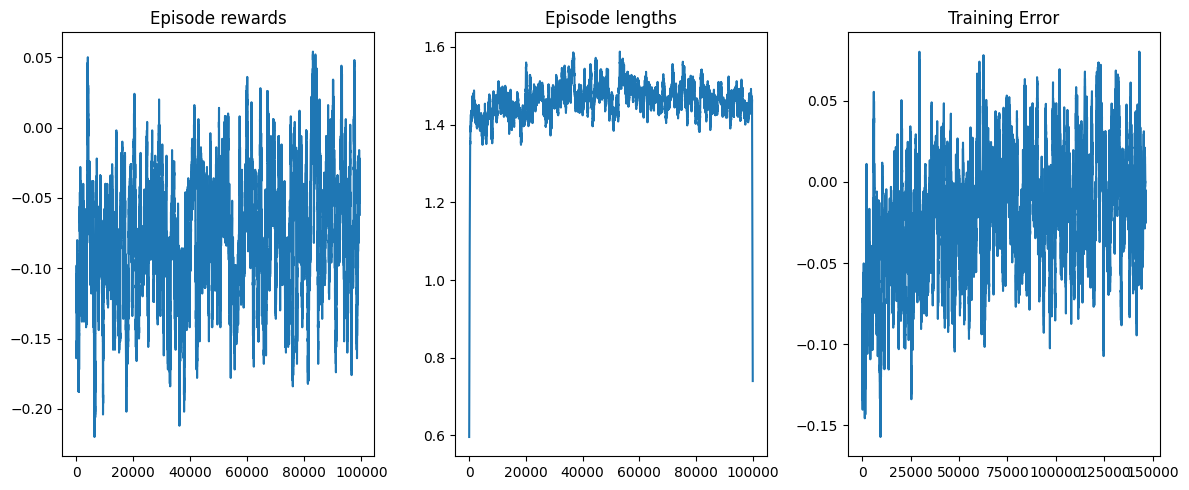

In [13]:
import matplotlib.pyplot as plt

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

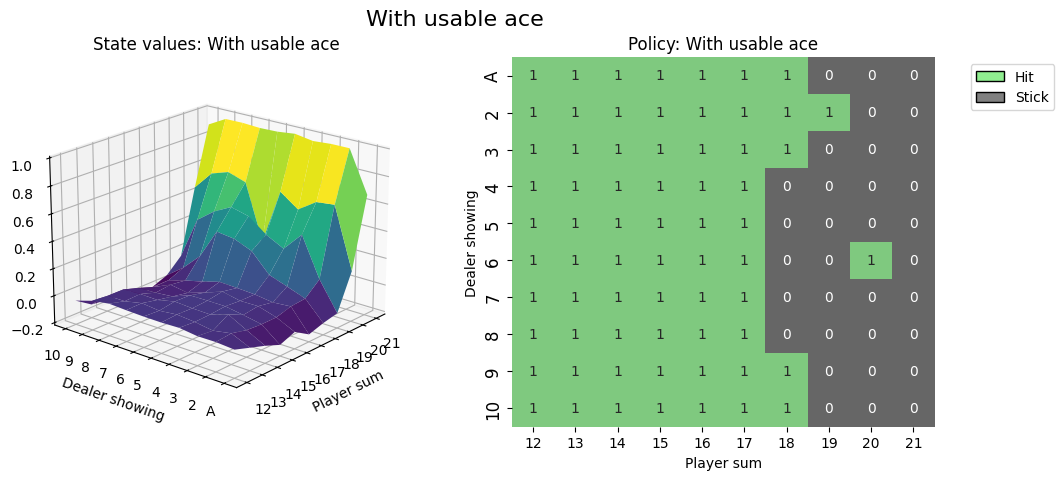

In [14]:
from collections import defaultdict
import seaborn as sns
from matplotlib.patches import Patch

def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

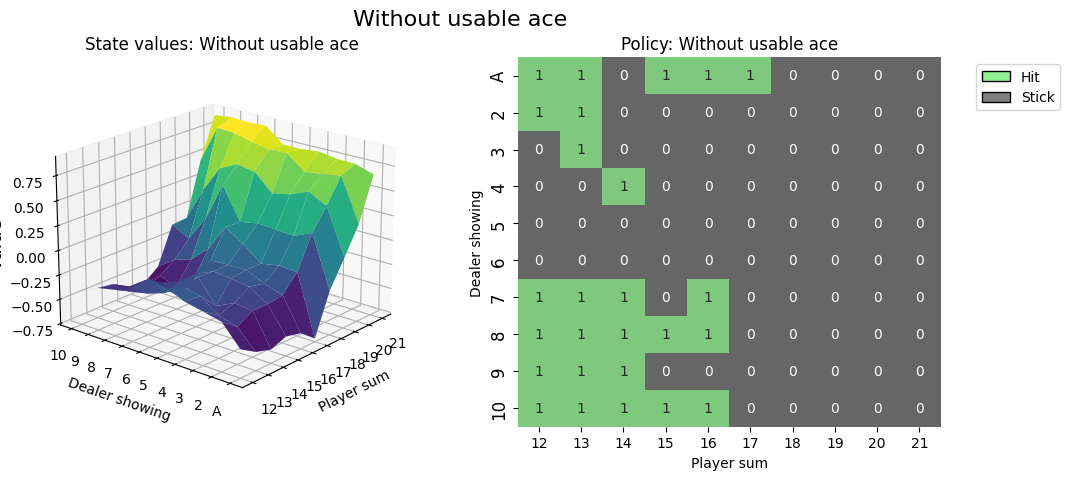

In [15]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

## Hoe goed presteert de agent?

In onderstaande code gaan we de agent een 10-tal keer laten blackjack spelen. 
Hierbij gaan we bijhouden hoe vaak de agent wint.

In [20]:
# Create the Blackjack environment
env = gym.make('Blackjack-v1')

# Define actions (0 = Stick, 1 = Hit)
actions = {0: 'Stick', 1: 'Hit'}

# Function to display the state
def display_state(state):
    player_hand, dealer_hand, usable_ace = state
    print(f"Player's hand: {player_hand}, Dealer's showing: {dealer_hand}, Usable ace: {usable_ace}")

# Function to play one game of Blackjack
def play_blackjack(env, agent=None, random=False):
    state = env.reset()
    done = False
    while not done:
        if agent is None and random:
            action = random.randint(0, 1)
        elif agent is None:
            action = int(input("Choose action - 0 (Stick) or 1 (Hit): "))
        else:
            action = agent.get_action(obs)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Optionally, display the state after the action
        display_state(state)
        
    return reward

# Number of games to play
num_games = 10
wins = 0

# Play the game num_games times
for i in range(num_games):
    reward = play_blackjack(env, agent)
    if reward > 0:
        wins += 1
    elif reward < 0:
        print(f"Game {i+1}: You lost! Reward: {reward}")
    else:
        print(f"Game {i+1}: Game ended in a draw. Reward: {reward}")

print(f"Total games played: {num_games}")
print(f"Number of wins: {wins}")


Player's hand: 7, Dealer's showing: 10, Usable ace: 0
Game 1: You lost! Reward: -1.0
Player's hand: 12, Dealer's showing: 3, Usable ace: 0
Player's hand: 14, Dealer's showing: 10, Usable ace: 1
Game 3: You lost! Reward: -1.0
Player's hand: 11, Dealer's showing: 10, Usable ace: 0
Game 4: You lost! Reward: -1.0
Player's hand: 18, Dealer's showing: 4, Usable ace: 0
Player's hand: 13, Dealer's showing: 2, Usable ace: 0
Player's hand: 11, Dealer's showing: 10, Usable ace: 0
Game 7: You lost! Reward: -1.0
Player's hand: 21, Dealer's showing: 10, Usable ace: 1
Player's hand: 12, Dealer's showing: 6, Usable ace: 0
Game 9: You lost! Reward: -1.0
Player's hand: 4, Dealer's showing: 10, Usable ace: 0
Game 10: You lost! Reward: -1.0
Total games played: 10
Number of wins: 4


## RL in neural networks

Het gebruik van Q-learning werkt goed als het aantal states en acties beperkt zijn.
Dit is echter zelden het geval, denk bijvoorbeeld aan een continue variabele zoals snelheid of locatie.

Een oplossing hiervoor is om de action-value functie die in Q-learning geoptimaliseerd wordt te benaderen ipv exact te berekenen.
Dit kan bijvoorbeeld door middel van een neuraal netwerk te gebruiken.
Er zijn verschillende model-structuren die hiervoor ontwikkeld zijn zoals:
- DQN (onderwerp van onderstaande demo)
- REINFORCE
- DDPG
- TD3
- PPO
- SAC

Voor we beginnen met het uitwerken van een model.
Bekijk [deze tutorial](https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial) en beantwoord de volgende vragen:
- Wat is de state en wat zijn de mogelijke acties?
- Wat is de structuur van het gebruikte DQN?
- Zijn er nieuwe hyperparameters gebruikt?
- Welke metriek wordt er gebruikt en waar wordt deze berekend?
- Hoe worden de gewichten aangepast?
- Waarvoor wordt de ReplayBuffer gebruikt?

**Antwoord:**
- Vraag 1:
- Vraag 2: 
- Vraag 3: 
- Vraag 4:
- Vraag 5:
- Vraag 6: 

Schrijf nu zelf de nodige code om het DQN-model toe te passen op het "Pole-cart" environment van gymnasium.
Hieronder vind je de nodige code om een visualisatie te maken van het uitvoeren van het pole-cart environment.
Om ervoor te zorgen dat de simulatie niet te snel stopt worden er altijd 1000 stappen gesimuleerd en wordt het gereset bij falen.
In de realiteit stop je het environment na een kritisch falen echter.

In [ ]:
import gymnasium as gym
from IPython.display import display, clear_output

def display_env(env):
    """Function to display the environment inline in a Jupyter notebook."""
    img = env.render()
    plt.imshow(img)
    plt.axis('off')
    display(plt.gcf())
    clear_output(wait=True)

env = gym.make('CartPole-v1', render_mode="rgb_array")
observation, info = env.reset(seed=42)
for _ in range(100):

    display_env(env)
    
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Create a neural network to approximate the Q-value function (regression for each possible action).
De bron van deze code kan je hier vinden: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Om een DQN-netwerk stabieler te trainen wordt een replay-buffer in het leven geroepen.
Deze houdt alle observaties bij die tegenkomen worden en maakt het mogelijk om hier samples uit te nemen.
Dit zorgt ervoor dat de tijds-correlatie verdwijnt wat het resultaat stabieler maakt.
Deze buffer schrijven we als volgt:

Daarna kunnen we het neuraal netwerk opbouwen om de Q-value horende bij de acties te benaderen voor elke state.
Het aantal inputs is dus gelijk aan de observaties en de outputs aan het aantal mogelijke acties.
De opbouw van het netwerk ertussen kan je vrij kiezen

Op basis van dit netwerk kunnenn we dan een agent definieren die het mogelijk maakt om het netwerk te trainen en acties te voorspellen.
De basis-structuur van deze agent ziet eruit als volgt:

In [ ]:
#training the agent
from tqdm import tqdm
from itertools import count

env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = DQNAgent(env, 
                 buffer_size=10000, 
                 batch_size=16, 
                 gamma=0.99, 
                 tau=1e-3, 
                 lr=5e-4, 
                 eps_start=0.9, eps_end=0.05, eps_decay=1000, 
                 layers=[128, 128])
num_episodes = 500

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and get its state
    state, info = env.reset()
    agent.reset()
    
    done = False
    while not done:
        action = agent.act(state)
        
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        agent.step(state, action, next_state, reward, done)
        
    episode_durations.append(agent.steps + 1)
    plot_durations()

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:

from IPython.display import display, clear_output

# Function to play one game of Blackjack
def play(env, agent):
    state, info = env.reset()
    done = False
    while not done:
        action = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        display_env(env)
        
    return reward

In [ ]:
play(env,agent)